Ascundem masejul in poza folosind un algorind SVD manual

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# Algoritm pentru metoda puterii
def power_method(A, max_iter=200, tol=1e-5):
    """Metoda Puterii pentru cea mai mare valoare proprie."""
    n = A.shape[0]
    v = np.random.rand(n)
    v = v / np.linalg.norm(v)
    lam_prev = 0
    for i in range(max_iter):
        v_new = A @ v
        v_new_norm = np.linalg.norm(v_new)
        if v_new_norm < 1e-9: break # Evitam impartirea la zero
        v_new = v_new / v_new_norm
        lam = v_new.T @ (A @ v_new)
        if abs(lam - lam_prev) < tol: break
        v = v_new
        lam_prev = lam
    return lam, v # Returneaza valoarea proprie maxima si vectorul propriu asociat acestei valori

def svd_manual(X, k):
    """SVD Manual folosind Deflatia"""
    M = np.dot(X.T, X)
    U_list, S_list, Vt_list = [], [], []
    M_curr = M.copy()

    for i in range(k):
        iteratii = 200
        eigenval, v = power_method(M_curr, max_iter=iteratii)

        if eigenval <= 1e-9: # Daca valorile sunt prea mici, ne oprim
            print(f"\n[Info] Ne-am oprit la componenta {i} din cauza preciziei.")
            break

        sigma = np.sqrt(eigenval)
        u = np.dot(X, v) / sigma

        S_list.append(sigma)
        Vt_list.append(v)
        U_list.append(u)

        # Deflatia
        M_curr = M_curr - eigenval * np.outer(v, v)

    return np.array(U_list).T, np.array(S_list), np.array(Vt_list)

# Variabile(poza, mesaj, scalarea)
MESAJ = "rares e cel mai mare muist "
SCALE_FACTOR = 1.0
NUME_FISIER = "DaniMocanu"

# Functie de conversie
def text_to_numbers(text):
    return [ord(c) for c in text]

# 1. Incarcare Imagine
print("\n>>> PREGATESC DATELE...")
files = [f for f in os.listdir('.') if f.endswith(('.jpg', '.png', '.jpeg'))]
if len(files) > 0:
    img = plt.imread(files[0])
    if img.ndim == 3 and img.shape[2] >= 3: img = img[:,:,:3]
    if img.max() <= 1.0: img = img * 255

    img_original_display = img.astype(np.uint8)
else:
    print("EROARE: Nu ai nicio poza incarcata in stanga!")
    img = None

if img is not None:
    img_float = img.astype(float)
    R, G, B = img_float[:,:,0], img_float[:,:,1], img_float[:,:,2]

    # 2. SVD MANUAL

    h_matrix, w_matrix = B.shape # Aflam numarul de linii si coloane
    k_necesar = min(h_matrix, w_matrix) # Aflam minimul dintre ele 2 pentru a afla numarul de valori singulare

    print(f"\n>>> ⚠️ INCEPE SVD MANUAL pe matricea {B.shape} pentru {k_necesar} componente.")
    start_time = time.time()

    U_man, S_man, Vt_man = svd_manual(B, k=k_necesar)

    end_time = time.time()
    print(f"\n>>> ✅ Gata! SVD Manual a durat: {end_time - start_time:.2f} secunde.")

    U, S, Vt = U_man, S_man, Vt_man

    ascii_vals = text_to_numbers(MESAJ)
    len_msg = len(ascii_vals)

    # Ascundere Mesaj
    S_mod = S.copy()
    # Le punem in coada vectorului S cu valori singulare
    idx_start = len(S) - len_msg
    idx_end = len(S)

    S_mod[idx_start:idx_end] = S[idx_start:idx_end] + (np.array(ascii_vals) * SCALE_FACTOR)

    # 3. Salvam datele din poza intr-un fisier .npz
    np.savez(f"{NUME_FISIER}.npz", U=U, S_mod=S_mod, Vt=Vt, S_original=S,
                 msg_len=len_msg, factor=SCALE_FACTOR, R=R, G=G)

    # 4. Reconstructie
    B_rec = U @ np.diag(S_mod) @ Vt
    img_stego = np.dstack((R, G, B_rec))
    img_stego_display = np.clip(img_stego, 0, 255).astype(np.uint8)

    print(f"✅ Fisierul '{NUME_FISIER}.npz' a fost salvat!")


>>> PREGATESC DATELE...

>>> ⚠️ INCEPE SVD MANUAL pe matricea (570, 674) pentru 570 componente.

[Info] Ne-am oprit la componenta 554 din cauza preciziei.

>>> ✅ Gata! SVD Manual a durat: 37.89 secunde.
✅ Fisierul 'DaniMocanu.npz' a fost salvat!


Afisam poza originala

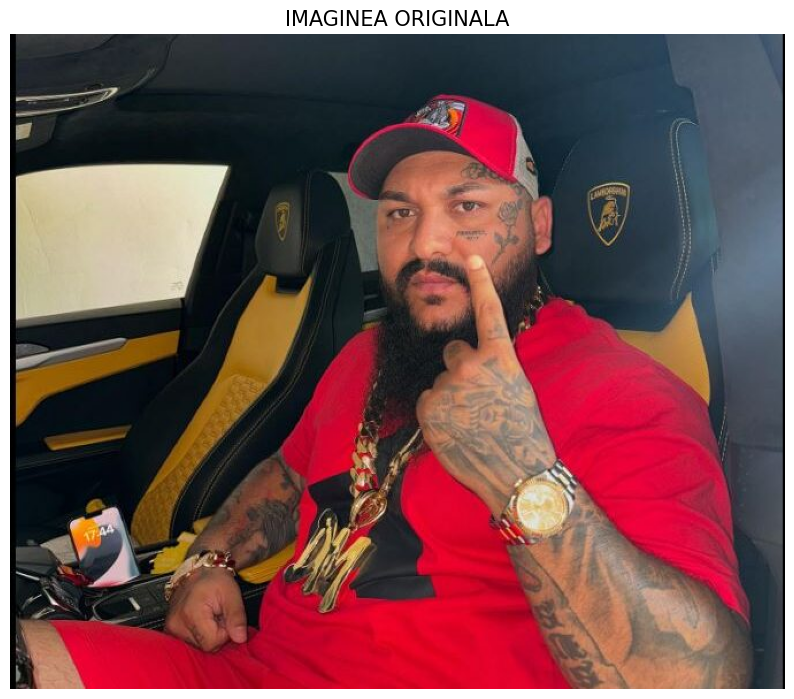

In [144]:
if 'img_original_display' in locals():
    plt.figure(figsize=(10, 10))
    plt.imshow(img_original_display)
    plt.title("IMAGINEA ORIGINALA", fontsize=15)
    plt.axis('off')
    plt.show()
else:
    print("⚠️ Ruleaza intai Celula 1!")

Afisam poza reconstruita (dupa introducerea mesajului)

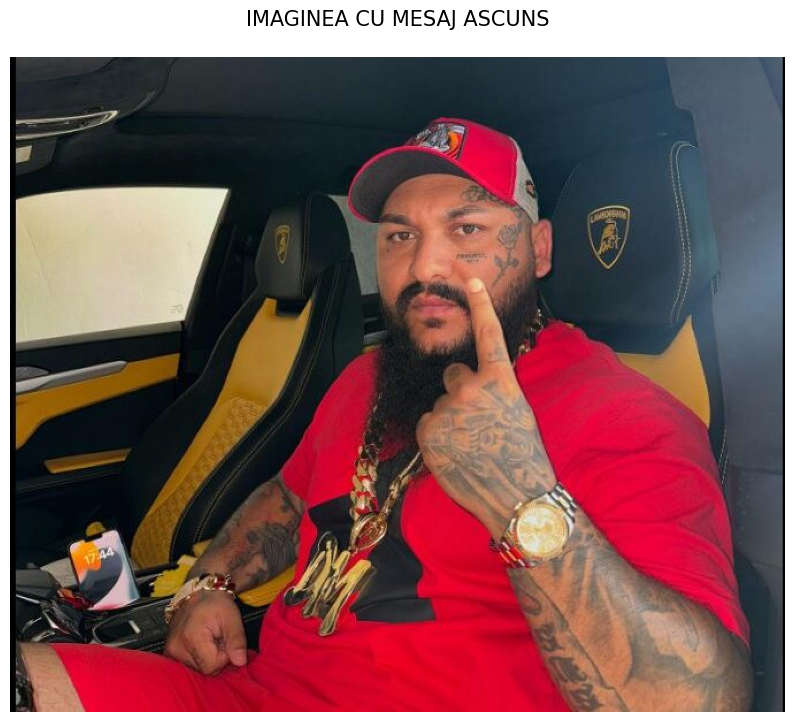

In [140]:
if 'img_stego_display' in locals():
    plt.figure(figsize=(10, 10))
    plt.imshow(img_stego_display)
    plt.title("IMAGINEA CU MESAJ ASCUNS\n", fontsize=15)
    plt.axis('off')
    plt.show()
else:
    print("⚠️ Ruleaza intai Celula 1!")

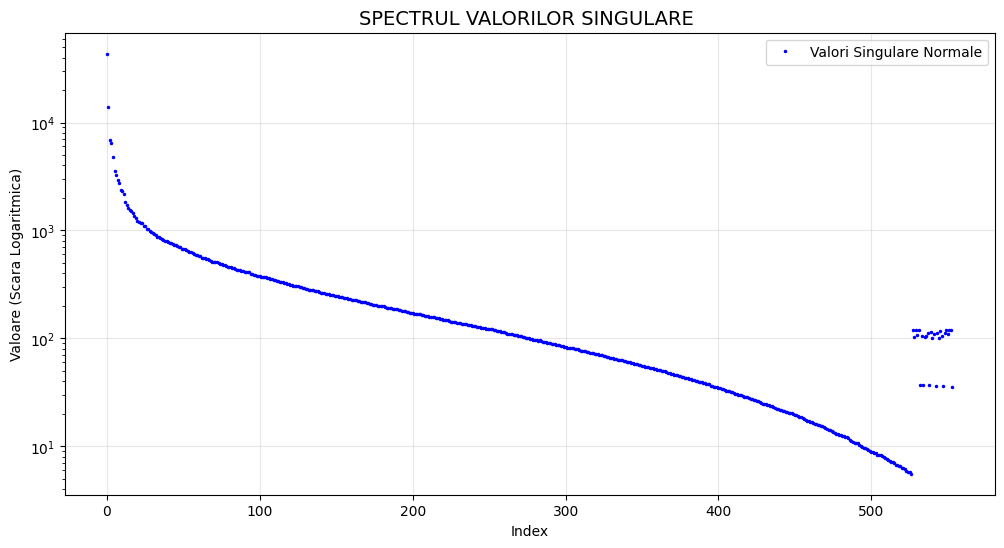

In [150]:
if 'S_mod' in locals():
    plt.figure(figsize=(12, 6))

    # Desenam toate punctele din vectorul S(cel modificat) cu albastru
    plt.semilogy(S_mod, 'b.', markersize=3, label='Valori Singulare Normale')

    plt.title("SPECTRUL VALORILOR SINGULARE ", fontsize=14)
    plt.xlabel("Index")
    plt.ylabel("Valoare (Scara Logaritmica)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()
else:
    print("⚠️ Ruleazq intai Celula 1!")

Extragem mesajul din imagine

In [149]:
# Functie de conversie
def numbers_to_text(numbers):
    chars = []
    for n in numbers:
        val = int(round(n))
        if 32 <= val <= 126: chars.append(chr(val))
        else: chars.append('?')
    return "".join(chars)

print(">>> DECRIPTAM DIN FISIERUL .NPZ...")

# Citim din fisierul salvat
try:
    data = np.load(f"{NUME_FISIER}.npz")
    S_mod_file = data['S_mod']
    S_orig_file = data['S_original']
    len_msg_file = int(data['msg_len'])
    scale_file = float(data['factor'])

    # Pentru a afla mesajul facem diferenta dintre vectorul modificat S si cel original
    diferenta = S_mod_file - S_orig_file
    valori_mesaj = diferenta[-len_msg_file:]
    coduri = valori_mesaj / scale_file

    mesaj_recuperat = numbers_to_text(coduri)

    print("\n" + "="*40)
    print(f" MESAJ: {mesaj_recuperat}")
    print("="*40 + "\n")

except:
    print("⚠️ Nu gasesc fisierul .npz! Ruleaza Celula 1.")

>>> DECRIPTAM DIN FISIERUL .NPZ...

 MESAJ: rares e cel mai mare muist 



Ascundem acelasi mesaj in aceeasi poza, dar de data aceasta folosind algoritmul SVD din libraria numpy pentru a compara timpul de rulare

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# Variabile
MESAJ = "rares suge cea mai mare pula ever"
SCALE_FACTOR = 0.01
NUME_FISIER = "DaniMocanu"

def text_to_numbers(text):
    return [ord(c) for c in text]

# 1. Încarcare Imagine
print(">>> PREGATESC DATELE...")
files = [f for f in os.listdir('.') if f.endswith(('.jpg', '.png', '.jpeg'))]
if len(files) > 0:
    img = plt.imread(files[0])
    if img.ndim == 3 and img.shape[2] >= 3: img = img[:,:,:3]
    if img.max() <= 1.0: img = img * 255
    # Pastram originalul in memorie pentru afisare
    img_original_display = img.astype(np.uint8)
else:
    print("EROARE: Nu ai nicio poza incarcata în stanga!")
    img = None

if img is not None:
    img_float = img.astype(float)
    R, G, B = img_float[:,:,0], img_float[:,:,1], img_float[:,:,2]

    # 2. SVD si Ascundere Mesaj
    print(f">>> Incep calculul SVD pe matricea {B.shape}...")

    start_time = time.time()

    U, S, Vt = np.linalg.svd(B, full_matrices=False)

    end_time = time.time()
    durata = end_time - start_time
    print(f" Timp executie SVD (Numpy): {durata:.4f} secunde")

    ascii_vals = text_to_numbers(MESAJ)
    len_msg = len(ascii_vals)

    S_mod = S.copy()
    S_mod[-len_msg:] = S[-len_msg:] + (np.array(ascii_vals) * SCALE_FACTOR)

    # 3. Salvam datele din poza intr-un fisier .npz
    np.savez(f"{NUME_FISIER}.npz", U=U, S_mod=S_mod, Vt=Vt, S_original=S,
             msg_len=len_msg, factor=SCALE_FACTOR, R=R, G=G)

    # 4. Reconstructie
    B_rec = U @ np.diag(S_mod) @ Vt
    img_stego = np.dstack((R, G, B_rec))
    # Pastram poza modificata in memorie pentru afisare
    img_stego_display = np.clip(img_stego, 0, 255).astype(np.uint8)

    print(f"✅ Fisierul '{NUME_FISIER}.npz' a fost salvat!")

>>> PREGATESC DATELE...
>>> Incep calculul SVD pe matricea (570, 674)...
 Timp executie SVD (Numpy): 0.1845 secunde
✅ GATA! Calculele sunt făcute. Rulează celulele de mai jos pentru grafice.
